In [14]:
import json
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
gc.disable()
from nltk.tokenize import sent_tokenize, word_tokenize

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation,TimeDistributed
from keras.layers import Bidirectional, LSTM
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate,BatchNormalization,MaxPooling1D, Conv1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, RepeatVector, Permute, merge
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from keras.callbacks import *
from keras.utils import to_categorical


In [2]:
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
#google word2vec
# from gensim.models import KeyedVectors as wv
# word_vectors = wv.load_word2vec_format('./input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary = True)
# EMBEDDING_DIM =300

#glove
word_vectors = {}
f = open('/home/samarth/embeddings/glove.840B.300d/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    word_vectors[word] = coefs
f.close()
EMBEDDING_DIM =300

In [4]:
# texts = []
# titles =[]
# labels =[]
# for label in ['fake','real']:
#     for typ in ['gossipcop','politifact']:
#         path = './../datasets/FakeNewsNet/code/fakenewsnet_dataset/'+typ+'/'+label+'/*/news content.json'
#         files = glob.glob(path)
#         for name in tqdm(files):
#             with open(name) as json_file:
#                 data = json.load(json_file)
#                 if label == 'fake': 
#                     labels.append(1)
#                 else:
#                     labels.append(0)
#                 texts.append(' '.join(word_tokenize(data['text'])))
#     #             titles.append(' '.join(word_tokenize(data['title'])))

# df = pd.DataFrame()
# # df['title'] = title
# df['text'] = texts
# df['label'] = labels
# df.to_pickle('./pickles/text.p')

In [5]:
df = pd.read_pickle('./pickles/text.p')

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2,random_state=1)

print("Train shape : ",df_train.shape)
print("Test shape : ",df_test.shape)

Train shape :  (17802, 2)
Test shape :  (4451, 2)


In [7]:
# df_train_pos = df_train[df_train['label']==1]
# df_train_neg = df_train[df_train['label']==0].sample(len(df_train_pos)*2,random_state=1)
# df_train = pd.concat([df_train_pos,df_train_neg])
# df_train = df_train.sample(frac=1,random_state=1)
# print("Train shape : ",df_train.shape)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

MAX_SEQUENCE_LENGTH=4000


tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(df_train['text'])
sequences = tokenizer.texts_to_sequences(df_train['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

train_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
train_Y = df_train['label']
train_Y = to_categorical(np.asarray(train_Y))

sequences = tokenizer.texts_to_sequences(df_test['text'])
test_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
test_Y = df_test['label']
test_Y = to_categorical(np.asarray(test_Y))

print('Number of positive and negative reviews in traing and validation set ')
print(train_Y.sum(axis=0))
print(test_Y.sum(axis=0))

/home/samarth/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/samarth/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Found 147878 unique tokens.
Number of positive and negative reviews in traing and validation set 
[13534.  4268.]
[3360. 1091.]


3658.860914503988
2032.0
7162.067879495823
110958


(array([1.6841e+04, 5.7400e+02, 2.0000e+02, 6.5000e+01, 4.7000e+01,
        2.7000e+01, 1.1000e+01, 1.4000e+01, 1.3000e+01, 1.0000e+01]),
 array([     0. ,  11095.8,  22191.6,  33287.4,  44383.2,  55479. ,
         66574.8,  77670.6,  88766.4,  99862.2, 110958. ]),
 <a list of 10 Patch objects>)

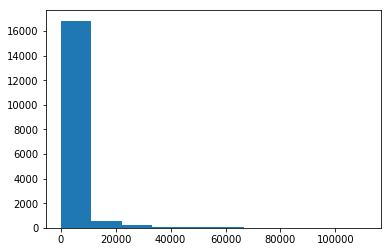

In [8]:

lengths = []
for sent in df_train['text']:
#     print(sent)
    lengths.append(len(sent))
#     if max(sent)>50:
#         print(sent)
print(np.mean(lengths))
print(np.median(lengths))
print(np.std(lengths))
print(np.max(lengths))
plt.hist(lengths,density=False)

In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        word_vector = word_vectors[word]
#     if word_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = word_vector
    except KeyError:
        continue

print(train_X.shape)
print(train_Y.shape)

(17802, 4000)
(17802, 2)


In [10]:
def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    # So we only measure F1 on the target y value:
    y_true = y_true[:, 0]
    y_pred = y_pred[:, 0]
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [11]:
## garbage collect
del df, df_test, df_train, word_vector, word_vectors
gc.collect()

7

In [15]:

dropout_prob = [0.2,0.2]
hidden_dims = 50
filter_sizes  = (3,8)
num_filters = 10
BATCH_SIZE = 32

convs = []
filter_sizes = [3,4,5]

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
l_merge = merge.Concatenate(axis=1)(convs)
l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - more complex convolutional neural network")
model.summary()

/home/samarth/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
W1108 10:39:23.572723 140670757365568 deprecation_wrapper.py:119] From /home/samarth/anaconda3/envs/tf36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



model fitting - more complex convolutional neural network
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 4000, 300)    44363700    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 3998, 128)    115328      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 3997, 128)    153728      embedding_2[0][0]                
__________________________________

/home/samarth/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/home/samarth/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


In [16]:
history = model.fit(train_X, train_Y, epochs=10,batch_size=BATCH_SIZE,validation_split=0.15)

W1108 10:39:30.320832 140670757365568 deprecation_wrapper.py:119] From /home/samarth/anaconda3/envs/tf36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 15131 samples, validate on 2671 samples
Epoch 1/10
15131/15131 [==============================] - 85s 6ms/step - loss: 0.4365 - acc: 0.8148 - val_loss: 0.3835 - val_acc: 0.8454
Epoch 2/10
15131/15131 [==============================] - 86s 6ms/step - loss: 0.3073 - acc: 0.8760 - val_loss: 0.3577 - val_acc: 0.8592
Epoch 3/10
15131/15131 [==============================] - 86s 6ms/step - loss: 0.1920 - acc: 0.9253 - val_loss: 0.4172 - val_acc: 0.8237
Epoch 4/10
15131/15131 [==============================] - 87s 6ms/step - loss: 0.1198 - acc: 0.9582 - val_loss: 0.5074 - val_acc: 0.8428
Epoch 5/10
15131/15131 [==============================] - 87s 6ms/step - loss: 0.0929 - acc: 0.9690 - val_loss: 0.5305 - val_acc: 0.8487
Epoch 6/10
15131/15131 [==============================] - 87s 6ms/step - loss: 0.0789 - acc: 0.9727 - val_loss: 0.8252 - val_acc: 0.8517
Epoch 7/10
15131/15131 [==============================] - 87s 6ms/step - loss: 0.0695 - acc: 0.9758 - val_loss: 1.3171 - val_acc:

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

KeyError: 'accuracy'

In [18]:

probs= model.predict(test_X,verbose=1,batch_size=50)
preds = [0]*len(probs)
# print(preds.shape)
# print(test_Y.shape)
# preds[probs[:,0]>=0.5] =1 
print(metrics.f1_score(test_Y, probs>=0.5))

4451/4451 [==============================] - 7s 2ms/step


ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting.

In [17]:
# metrics.f1_score(test_Y, (probs>thresh).astype(int)))